# Install and Import Necessary Libraries

In [1]:
! pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm
! pip install --upgrade pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 29.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 28.2 MB/s eta 0:00:0000:0100:01


In [2]:
try:
    import pylibjpeg
except:
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

import pydicom
pydicom.__version__

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset

# Data Access and Analysis

In [4]:
RSNA_2022_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'

In [5]:
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [6]:
len(df_train)

54706

In [7]:
len(df_train[df_train['cancer'] == 0])

53548

In [8]:
len(df_train[df_train['biopsy'] == 1])

2969

In [9]:
len(df_train[df_train['cancer'] == 1])

1158

In [10]:
len(df_train[df_train['invasive'] == 1])

818

In [11]:
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])

818

<AxesSubplot:xlabel='class', ylabel='count'>

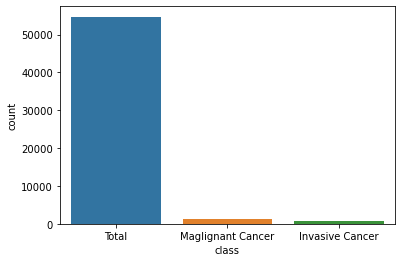

In [12]:
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

<AxesSubplot:xlabel='class', ylabel='count'>

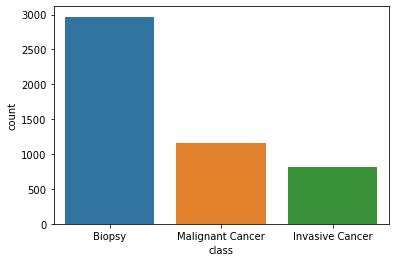

In [13]:
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [14]:
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1811

In [15]:
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

1158

<AxesSubplot:xlabel='class', ylabel='count'>

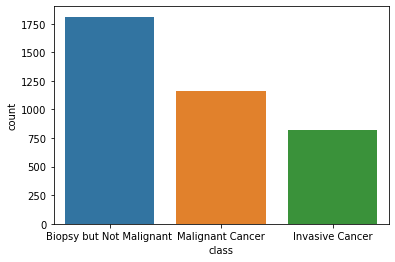

In [16]:
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [17]:
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [18]:
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<AxesSubplot:xlabel='class', ylabel='count'>

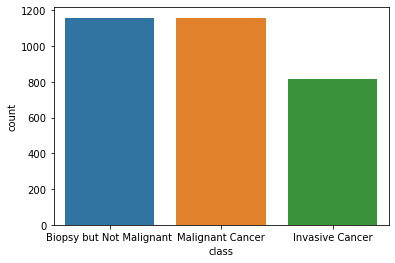

In [19]:
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

# Medical Image Data in DICOM 

In [20]:
dcmfnm = '/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'

ds = pydicom.dcmread(dcmfnm, force = True)
print("Display Meta Information\n", ds)

# Get information with keyword
p_id = ds.PatientID
print("\n>Patient ID=", p_id, type(p_id))

Display Meta Information
 Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0

In [ ]:
img = ds.pixel_array
plt.imshow(img)
plt.show()

In [22]:
img

array([[1803, 1845, 1874, ..., 3044, 3044, 3044],
       [1834, 1866, 1902, ..., 3044, 3044, 3044],
       [1866, 1894, 1903, ..., 3044, 3044, 3044],
       ...,
       [2250, 2259, 2240, ..., 3044, 3044, 3044],
       [2246, 2256, 2235, ..., 3044, 3044, 3044],
       [2196, 2217, 2226, ..., 3044, 3044, 3044]], dtype=uint16)

In [23]:
img.shape

(5355, 4915)

In [24]:
ds = pydicom.dcmread(os.path.join(RSNA_2022_path + '/' + str(DF_train.loc[0, 'patient_id']) + '/' + str(DF_train.loc[0, 'image_id']) + '.dcm'), force = True)
img = ds.pixel_array.astype(np.float32)
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
img.shape

(4096, 3328)

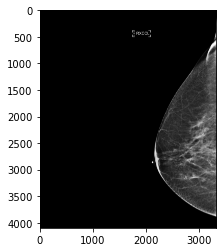

In [26]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [27]:
img = np.resize(img, (1024, 1024))

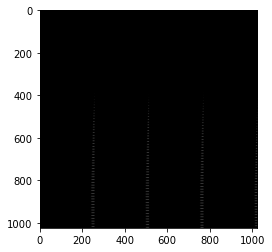

In [28]:
plt.imshow(img, cmap = 'gray')
plt.show()

# Creation of Dataset and Data Loader for Training and Validation

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [30]:
class RSNA_Dataset(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_2022_path + '/' + str(DF_train.loc[index, 'patient_id']) + '/' + str(DF_train.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True)
        image = ds.pixel_array.astype(np.float32)
        image = np.resize(image, (300, 300))
        #image = image.convert('RGB')
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [31]:
dataset = RSNA_Dataset(DF_train, RSNA_2022_path, transform)

In [32]:
len(dataset)

2316

In [33]:
x, t = dataset[0]

In [34]:
x

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [35]:
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([1, 300, 300]))

In [36]:
t

tensor(0)

In [37]:
train, val = torch.utils.data.random_split(dataset = dataset, lengths = [1800, 516], generator = torch.Generator().manual_seed(42))

In [38]:
len(train), len(val)

(1800, 516)

In [39]:
can = 0
for i in range(len(val)):
    x, t = val[i]
    if t == 1:
        can += 1
print(can / len(val))        

0.5038759689922481


In [40]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 128)

# Creation of Dataset and Visualization (No Resize)

In [41]:
class RSNA_Dataset_Visual(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_2022_path + '/' + str(DF_train.loc[index, 'patient_id']) + '/' + str(DF_train.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True)
        image = ds.pixel_array.astype(np.float32)
        # image = np.resize(image, (300, 300))
        #image = image.convert('RGB')
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [42]:
dataset_visual = RSNA_Dataset_Visual(DF_train, RSNA_2022_path, transform)

In [43]:
train_visual, val_visual = torch.utils.data.random_split(dataset = dataset_visual, lengths = [1800, 516], generator = torch.Generator().manual_seed(42))

In [44]:
def img_display(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    # npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

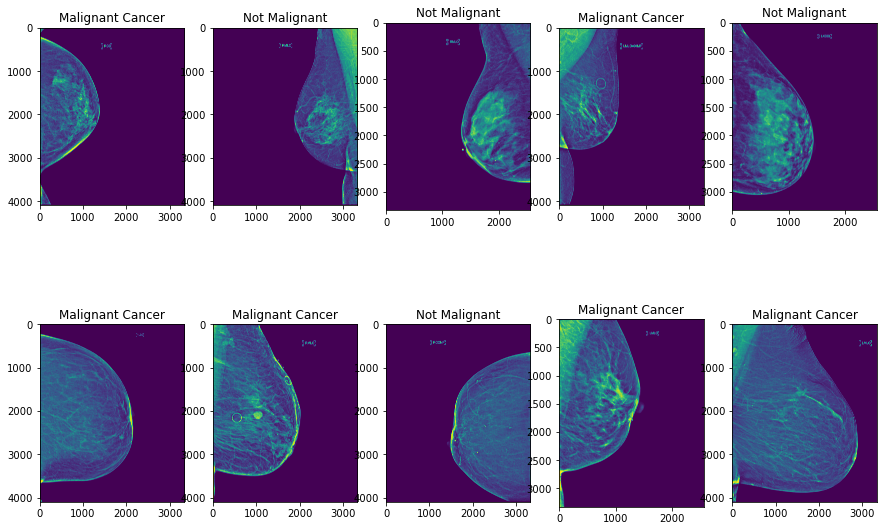

In [45]:
# get some training images
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = train_visual[i]
        ax.imshow(img_display(image).squeeze(0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

# Creation of Model

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3,stride = 2,padding = 1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3,stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3,stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3,stride = 2, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64 * 5 * 5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.logsigmoid(self.fc3(x))
        return x

In [47]:
model = Net() # On CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = Net().to(device) # On GPU
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


# Training and Validation

In [48]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor = 0.2, total_iters = 10)

In [ ]:
n_epochs = 6
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device) # on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        pred = torch.sigmoid(outputs)
        target = target_.unsqueeze(1).float()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        pred = pred > 0.38
        accuracy = (target == pred).sum().item() / target.size(0)

        if (batch_idx) % 3 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * accuracy)
    train_loss.append(running_loss / total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * accuracy):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device) # on GPU
            outputs_t = model(data_t)
            pred_t = torch.sigmoid(outputs_t)
            target_t = target_t.unsqueeze(1).float()
            loss_t = criterion(pred_t, target_t)
            batch_loss += loss_t.item()
            pred_t = pred_t > 0.38
            accuracy_t = (target_t == pred_t).sum().item() / target_t.size(0)
        val_acc.append(100 * accuracy_t)
        val_loss.append(batch_loss / len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * accuracy_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'cancer_classification.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/6], Step [0/14], Loss: 0.7191
Epoch [1/6], Step [3/14], Loss: 0.8806
Epoch [1/6], Step [6/14], Loss: 0.6823
Epoch [1/6], Step [9/14], Loss: 0.7216
Epoch [1/6], Step [12/14], Loss: 0.7172

train loss: 0.7660, train acc: 45.3125
validation loss: 0.6964, validation acc: 25.0000

Detected network improvement, saving current model
Epoch 2

Epoch [2/6], Step [0/14], Loss: 0.6754
Epoch [2/6], Step [3/14], Loss: 0.7376
Epoch [2/6], Step [6/14], Loss: 0.7044
Epoch [2/6], Step [9/14], Loss: 0.7785
Epoch [2/6], Step [12/14], Loss: 0.7326

train loss: 0.7486, train acc: 42.1875
validation loss: 0.6947, validation acc: 25.0000

Detected network improvement, saving current model
Epoch 3

Epoch [3/6], Step [0/14], Loss: 0.7201


# Save and Visualize the Results

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label = 'train')
plt.plot(val_acc, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Loss")
plt.plot(train_loss, label = 'train')
plt.plot(val_loss, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('loss', fontsize = 12)
plt.legend(loc = 'best')

In [ ]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('cancer_classification.pt'))

In [ ]:
model = Net() # CPU
dataiter = iter(val_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        model.eval()
        image_visual, label_visual = val_visual[i]
        image, label = images[i], labels[i]
        ax.imshow(img_display(image_visual.squeeze(0))) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = torch.sigmoid(output_)
        if output_.item() > 0.38:
            k = (label.item() == 1)
        else:
            k = (label.item() == 0)
        ax.set_title(str(arthopod_types[label.item()]) + ":" + str(k)) # add label

In [ ]:
model = Net() # CPU
model.eval()
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_loader:
        outputs = model(inputs) # Feed Network
        outputs = torch.sigmoid(outputs)
        
        for i in range(len(outputs)):
            output = outputs[i]            
            if output.item() > 0.38:
                y_pred.append(int(1)) # Save Prediction
            else:
                y_pred.append(int(0)) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Not Malignant', 'Malignant Cancer')

In [ ]:
# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [ ]:
target_name = {'Not Malignant': 0, 'Malignant Cancer': 1}
print('Confusion Matrix')
plt.figure(figsize = (10, 10))
_ = sns.heatmap(cm.T, annot = True, fmt = 'd', cbar = True, square = True, xticklabels = target_name.keys(),
             yticklabels = target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# Prediction of Test Data

In [ ]:
RSNA_test_path = '/kaggle/input/rsna-breast-cancer-detection/test_images'

In [ ]:
df_test = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')
df_test.head()

In [ ]:
class RSNA_Testset(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_test_path + '/' + str(df_test.loc[index, 'patient_id']) + '/' + str(df_test.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True)
        image = ds.pixel_array.astype(np.float32)
        image = np.resize(image, (300, 300))
        #image = image.convert('RGB')
        #label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image#, label

In [ ]:
testset = RSNA_Testset(df_test, RSNA_test_path, transform)

In [ ]:
model.eval()
cancer = []
for i in range(len(testset)):
    out = testset[i].unsqueeze_(0)
    out = model(out)
    out = torch.sigmoid(out)
    cancer.append(out.item())
cancer

In [ ]:
df_test['cancer'] = cancer
df_test

In [ ]:
submission = df_test.loc[:, 'prediction_id':'cancer']
submission

In [ ]:
submission = submission.groupby('prediction_id').mean().reset_index()
submission

In [ ]:
submission = pd.DataFrame(data = {'prediction_id': df_test['prediction_id'], 'cancer': cancer})
submission

In [ ]:
submission = submission.groupby('prediction_id').max().reset_index()
submission

In [ ]:
submission.to_csv('submission.csv', index = False)